# Open3D Guide: 5. RGBD Images and Odometry

Sources:

- [https://www.open3d.org/docs/latest/tutorial/Basic/rgbd_image.html](https://www.open3d.org/docs/latest/tutorial/Basic/rgbd_image.html).
- [https://www.open3d.org/docs/latest/tutorial/Basic/rgbd_odometry.html](https://www.open3d.org/docs/latest/tutorial/Basic/rgbd_odometry.html).

Summary of contents:

- Redwood dataset: RGB, Depth and Co.
- RGBD Odometry
  - Camera parameters: 
    - `o3d.camera.PinholeCameraIntrinsic`
    - `o3d.io.read_pinhole_camera_intrinsic`
  - Read RGBD images:
    - `o3d.geometry.RGBDImage.create_from_color_and_depth`
    - `o3d.geometry.PointCloud.create_from_rgbd_image`
  - Compute odometry from two RGBD image pairs: `o3d.pipelines.odometry.compute_rgbd_odometry`
    - `o3d.pipelines.odometry.RGBDOdometryJacobianFromColorTerm()`
    - `o3d.pipelines.odometry.RGBDOdometryJacobianFromHybridTerm()`
  - Visualize RGBD image pairs

In [2]:
import sys
import os
import copy

# Add the directory containing 'examples' to the Python path
notebook_directory = os.getcwd()
parent_directory = os.path.dirname(notebook_directory)  # Parent directory
sys.path.append(parent_directory)

In [5]:
import open3d as o3d
from examples import open3d_example as o3dex
import numpy as np
import matplotlib.pyplot as plt

## Redwood dataset: RGB, Depth and Co.

In [4]:
print("Read Redwood dataset")
color_raw = o3d.io.read_image("../images/redwood/livingroom1-color/00000.jpg")
depth_raw = o3d.io.read_image("../images/redwood/livingroom1-depth-clean/00000.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)

Read Redwood dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


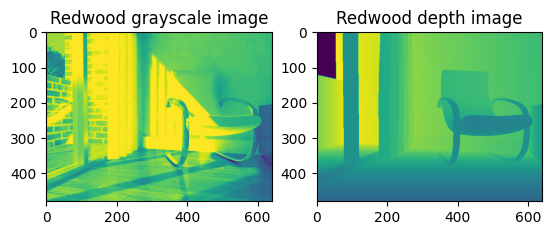

In [6]:
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [13]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)
    )
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

## RGBD Odometry

### Camera Parameters

An RGBD odometry finds the camera movement between two consecutive RGBD image pairs. The input are two instances of RGBDImage. The output is the motion in the form of a rigid body transformation. We need a `camera.json` file with the camera's intrinsic parameters; I found the format in the internet and the values in the tutorial:

`camera_primesense.json`:

```json
{
    "width": 640,
    "height": 480,
    "intrinsic_matrix":
    [
        525.0,
        0.0,
        319.5,
        0.0,
        525.0,
        239.5,
        0.0,
        0.0,
        1.0
    ]
}
```

In [23]:
# I had to manually create the JSON file
# I found the format in the internet and the values in the tutorial
pinhole_camera_intrinsic = o3d.io.read_pinhole_camera_intrinsic(
    "../images/redwood/camera_primesense.json"
)
print(pinhole_camera_intrinsic.intrinsic_matrix)

[[525.    0.    0. ]
 [  0.  525.    0. ]
 [319.5 239.5   1. ]]


##

### Read RGBD image

In [24]:
# Open3D assumes the color image and depth image are synchronized and registered in the same coordinate frame
source_color = o3d.io.read_image("../images/redwood/livingroom1-color/00000.jpg")
source_depth = o3d.io.read_image("../images/redwood/livingroom1-depth-clean/00000.png")
target_color = o3d.io.read_image("../images/redwood/livingroom1-color/00001.jpg")
target_depth = o3d.io.read_image("../images/redwood/livingroom1-depth-clean/00001.png")
source_rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    source_color, source_depth)
target_rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    target_color, target_depth)
target_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    target_rgbd_image, pinhole_camera_intrinsic)

### Compute odometry from two RGBD image pairs

In [25]:
# This code block calls two different RGBD odometry methods.
# The first one is from [Steinbrucker2011]. It minimizes photo consistency of aligned images.
# The second one is from [Park2017]. In addition to photo consistency, 
# it implements constraint for geometry.
# Both functions run in similar speed, but [Park2017] is more accurate 
# in our test on benchmark datasets and is thus the recommended method.
#
# Parameters in OdometryOption():
# minimum_correspondence_ratio: After alignment, measure the overlapping ratio of two RGBD images.
#   If overlapping region of two RGBD image is smaller than specified ratio, 
#   the odometry module regards that this is a failure case.
# max_depth_diff: In depth image domain, 
#   if two aligned pixels have a depth difference less than specified value,
#   they are considered as a correspondence.
#   Larger value induce more aggressive search, but it is prone to unstable result.
# min_depth and max_depth: Pixels that has smaller 
#   or larger than specified depth values are ignored.
option = o3d.pipelines.odometry.OdometryOption()
odo_init = np.identity(4)
print(option)

[success_color_term, trans_color_term,
 info] = o3d.pipelines.odometry.compute_rgbd_odometry(
     source_rgbd_image, target_rgbd_image, pinhole_camera_intrinsic, odo_init,
     o3d.pipelines.odometry.RGBDOdometryJacobianFromColorTerm(), option)
[success_hybrid_term, trans_hybrid_term,
 info] = o3d.pipelines.odometry.compute_rgbd_odometry(
     source_rgbd_image, target_rgbd_image, pinhole_camera_intrinsic, odo_init,
     o3d.pipelines.odometry.RGBDOdometryJacobianFromHybridTerm(), option)   

OdometryOption class.
iteration_number_per_pyramid_level = [ 20, 10, 5, ] 
depth_diff_max = 0.030000
depth_min = 0.000000
depth_max = 4.000000


### Visualize RGBD image pairs

In [26]:
# The RGBD image pairs are converted into point clouds and rendered together. 
# Note that the point cloud representing the first (source) RGBD image is transformed
# with the transformation estimated by the odometry.
# After this transformation, both point clouds are aligned.
if success_color_term:
    print("Using RGB-D Odometry")
    print(trans_color_term)
    source_pcd_color_term = o3d.geometry.PointCloud.create_from_rgbd_image(
        source_rgbd_image, pinhole_camera_intrinsic)
    source_pcd_color_term.transform(trans_color_term)
    o3d.visualization.draw_geometries([target_pcd, source_pcd_color_term],
                                      zoom=0.48,
                                      front=[0.0999, -0.1787, -0.9788],
                                      lookat=[0.0345, -0.0937, 1.8033],
                                      up=[-0.0067, -0.9838, 0.1790])
if success_hybrid_term:
    print("Using Hybrid RGB-D Odometry")
    print(trans_hybrid_term)
    source_pcd_hybrid_term = o3d.geometry.PointCloud.create_from_rgbd_image(
        source_rgbd_image, pinhole_camera_intrinsic)
    source_pcd_hybrid_term.transform(trans_hybrid_term)
    o3d.visualization.draw_geometries([target_pcd, source_pcd_hybrid_term],
                                      zoom=0.48,
                                      front=[0.0999, -0.1787, -0.9788],
                                      lookat=[0.0345, -0.0937, 1.8033],
                                      up=[-0.0067, -0.9838, 0.1790])

Using RGB-D Odometry
[[ 9.99993638e-01 -8.52277086e-04 -3.46382984e-03 -4.83924875e-03]
 [ 8.24483800e-04  9.99967520e-01 -8.01738263e-03  1.41342241e-02]
 [ 3.47055037e-03  8.01447575e-03  9.99961861e-01 -1.32216362e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Using Hybrid RGB-D Odometry
[[ 9.99998962e-01  1.40779013e-03 -3.07161739e-04 -1.39777338e-03]
 [-1.40958187e-03  9.99981524e-01 -5.91313269e-03  1.47105778e-02]
 [ 2.98831614e-04  5.91355953e-03  9.99982470e-01 -4.79518371e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
